In [ ]:
install.packages(c("DBI", "bigrquery", "dplyr", "ggplot2", "caret", "e1071", "pROC", "stats", "corrplot"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘stats’ is a base package, and should not be updated”
also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘iterators’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘clock’, ‘rapidjsonr’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘recipes’, ‘reshape2’, ‘proxy’




In [ ]:
library(bigrquery)

In [ ]:
bq_auth()


Is it OK to cache OAuth access credentials in the folder ~/.cache/gargle
between R sessions?
1: Yes
2: No


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=7a3892eea848a623cdcde9efb07897a3&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQVZNQnNKaVFZZDJ1Zl9nWEhrYmc2a0daVlRPeG9UcktQRF9FUkY0R2hOcF8yZEJub3BZamtCd2thTzdMdTRMcldnMzRMdyIsInN0YXRlIjoiN2EzODkyZWVhODQ4YTYyM2NkY2RlOWVmYjA3ODk3YTMifQ==


In [ ]:
# Load necessary libraries
library(DBI)
library(bigrquery)
library(dplyr)
library(ggplot2)
library(caret)
library(e1071) # For confusionMatrix
library(pROC)  # For ROC curve and AUC
library(stats) # For t.test, chisq.test
library(corrplot) # For correlation plots

# Set your Google Cloud Project ID
project_id <- "credit-risk-prediction-project"

# Authenticate (this will prompt you to open a browser for authentication)
# If it asks for a token, copy-paste it from the browser.
# On Colab R runtime, this usually works automatically with your logged-in Google account.
# bq_auth(email = "your-google-email@example.com") # Optional, if you have issues

# Connect to BigQuery
con <- dbConnect(
  bigrquery::bigquery(),
  project = project_id,
  dataset = "credit_data" # Your dataset name
)

# Pull the cleaned data into an R DataFrame
query <- "SELECT * FROM `credit-risk-prediction-project.credit_data.german_credit_cleaned_sql`"
german_credit_df <- dbGetQuery(con, query)

# Disconnect from BigQuery (good practice)
dbDisconnect(con)

# Display the first few rows and structure of the data
head(german_credit_df)
str(german_credit_df)
summary(german_credit_df)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


corrplot 0.95 loaded



Age,Sex,Job,Housing,SavingAccountsStatus,CheckingAccountStatus,LoanAmount,LoanDuration,Purpose,RiskStatus,AgeGroup,LoanDurationCategory,IsDefault
<int>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
19,female,2,rent,little,NA,1980,9,furniture/equipment,bad,18-24,Short (<=12 months),1
19,female,1,rent,rich,moderate,983,12,furniture/equipment,good,18-24,Short (<=12 months),0
20,male,2,own,little,NA,1313,9,furniture/equipment,good,18-24,Short (<=12 months),0
20,female,2,own,rich,moderate,1577,11,furniture/equipment,good,18-24,Short (<=12 months),0
20,male,3,rent,little,little,1107,12,radio/TV,good,18-24,Short (<=12 months),0
20,female,2,rent,NA,NA,4675,12,car,good,18-24,Short (<=12 months),0


tibble [1,000 × 13] (S3: tbl_df/tbl/data.frame)
 $ Age                  : int [1:1000] 19 19 20 20 20 20 20 20 20 20 ...
 $ Sex                  : chr [1:1000] "female" "female" "male" "female" ...
 $ Job                  : int [1:1000] 2 1 2 2 3 2 2 2 2 2 ...
 $ Housing              : chr [1:1000] "rent" "rent" "own" "own" ...
 $ SavingAccountsStatus : chr [1:1000] "little" "rich" "little" "rich" ...
 $ CheckingAccountStatus: chr [1:1000] "NA" "moderate" "NA" "moderate" ...
 $ LoanAmount           : int [1:1000] 1980 983 1313 1577 1107 4675 1282 585 674 2221 ...
 $ LoanDuration         : int [1:1000] 9 12 9 11 12 12 12 12 12 15 ...
 $ Purpose              : chr [1:1000] "furniture/equipment" "furniture/equipment" "furniture/equipment" "furniture/equipment" ...
 $ RiskStatus           : chr [1:1000] "bad" "good" "good" "good" ...
 $ AgeGroup             : chr [1:1000] "18-24" "18-24" "18-24" "18-24" ...
 $ LoanDurationCategory : chr [1:1000] "Short (<=12 months)" "Short (<=12 months)" 

      Age            Sex                 Job          Housing         
 Min.   :19.00   Length:1000        Min.   :0.000   Length:1000       
 1st Qu.:27.00   Class :character   1st Qu.:2.000   Class :character  
 Median :33.00   Mode  :character   Median :2.000   Mode  :character  
 Mean   :35.55                      Mean   :1.904                     
 3rd Qu.:42.00                      3rd Qu.:2.000                     
 Max.   :75.00                      Max.   :3.000                     
 SavingAccountsStatus CheckingAccountStatus   LoanAmount     LoanDuration 
 Length:1000          Length:1000           Min.   :  250   Min.   : 4.0  
 Class :character     Class :character      1st Qu.: 1366   1st Qu.:12.0  
 Mode  :character     Mode  :character      Median : 2320   Median :18.0  
                                            Mean   : 3271   Mean   :20.9  
                                            3rd Qu.: 3972   3rd Qu.:24.0  
                                            Max.   :1

In [ ]:
german_credit_df$IsDefault <- factor(german_credit_df$IsDefault, levels = c(0, 1), labels = c("Good", "Default"))

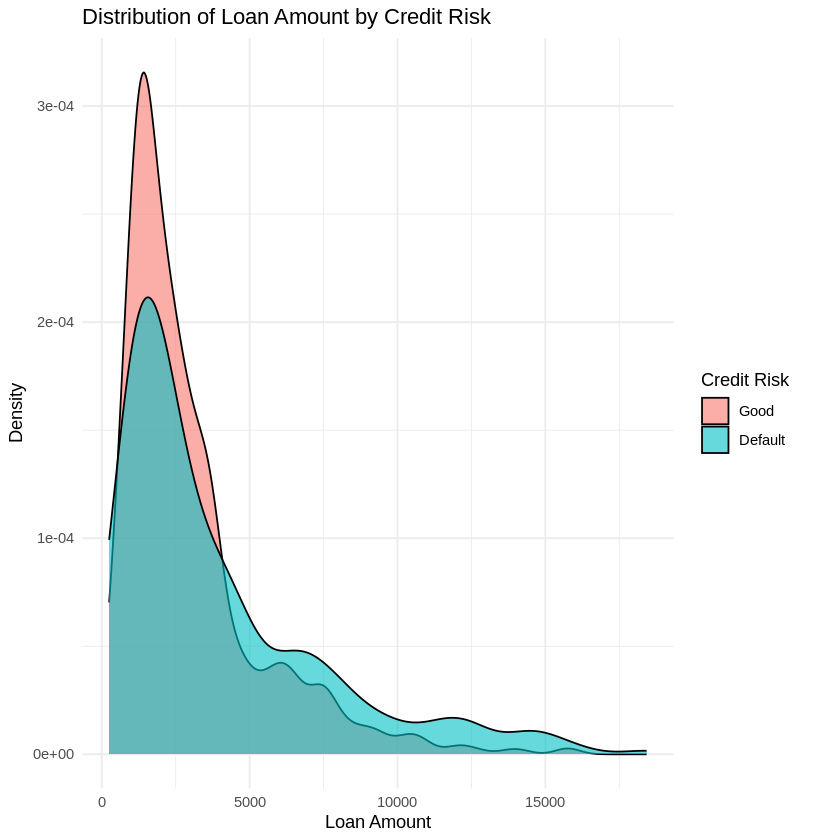

In [ ]:
ggplot(german_credit_df, aes(x = LoanAmount, fill = IsDefault)) +
  geom_density(alpha = 0.6) +
  labs(title = "Distribution of Loan Amount by Credit Risk",
       x = "Loan Amount",
       y = "Density",
       fill = "Credit Risk") +
  theme_minimal()

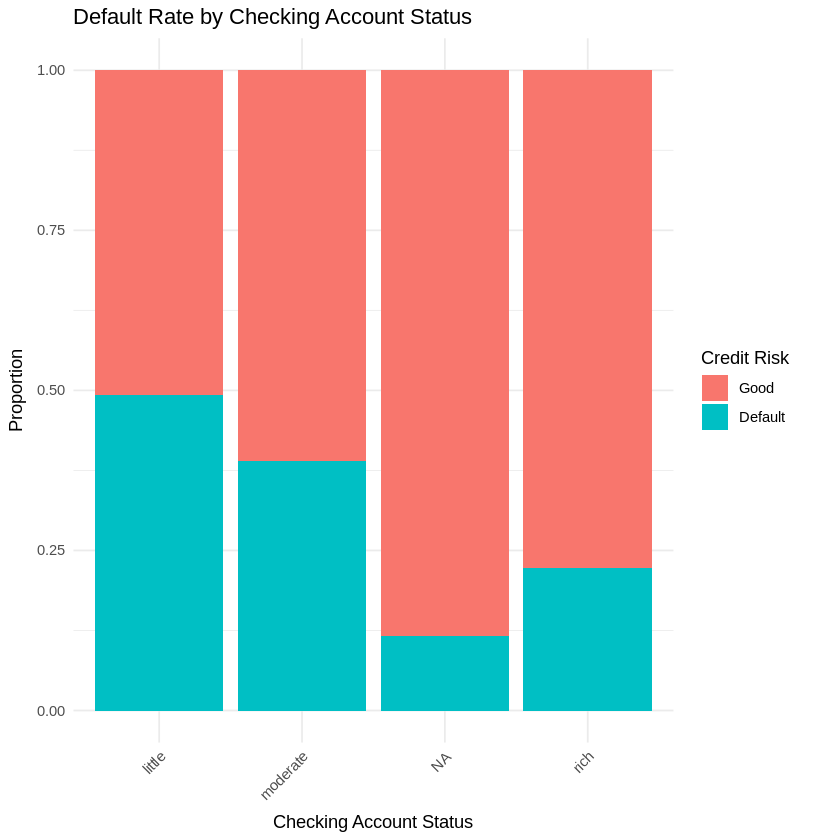

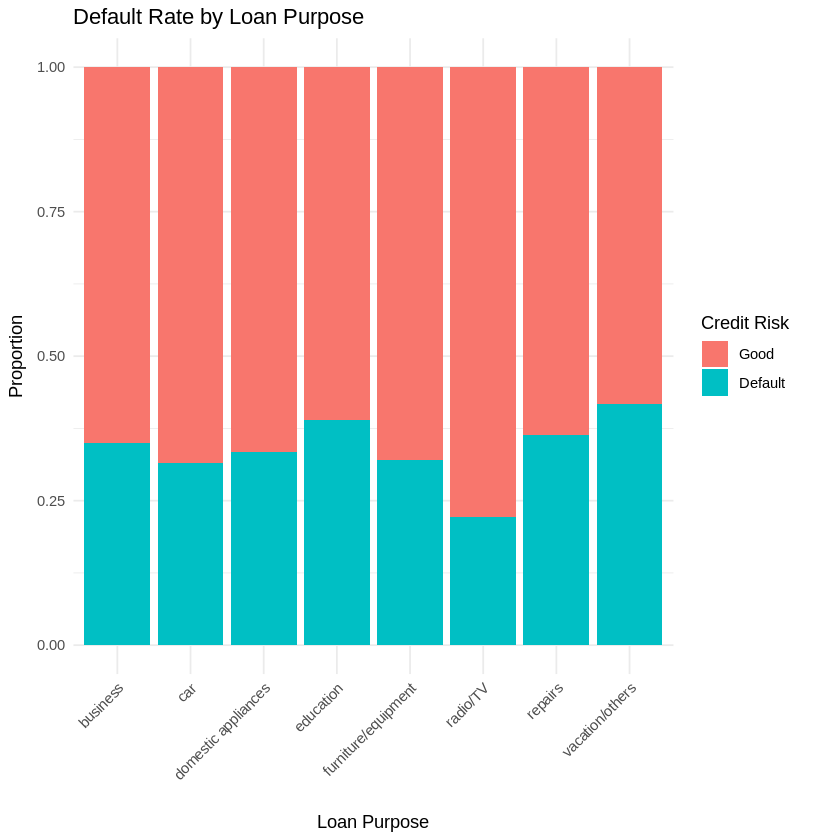

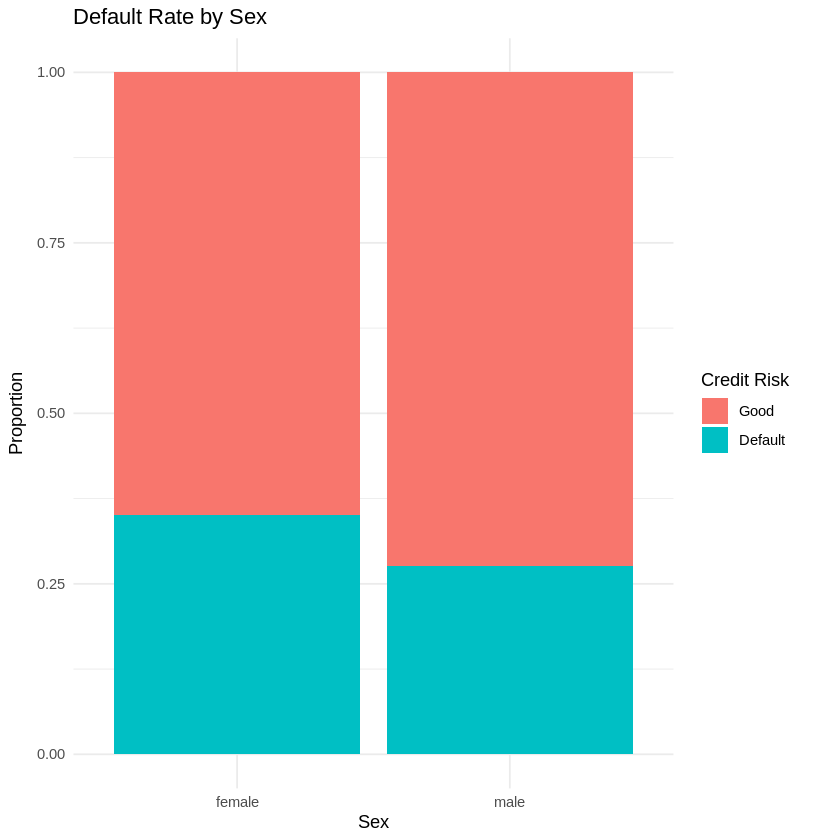

In [ ]:
# Example: Checking Account Status
ggplot(german_credit_df, aes(x = CheckingAccountStatus, fill = IsDefault)) +
  geom_bar(position = "fill") + # "fill" makes it a percentage stack
  labs(title = "Default Rate by Checking Account Status",
       x = "Checking Account Status",
       y = "Proportion",
       fill = "Credit Risk") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Example: Purpose
ggplot(german_credit_df, aes(x = Purpose, fill = IsDefault)) +
  geom_bar(position = "fill") +
  labs(title = "Default Rate by Loan Purpose",
       x = "Loan Purpose",
       y = "Proportion",
       fill = "Credit Risk") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# New Plot: Default Rate by Sex
ggplot(german_credit_df, aes(x = Sex, fill = IsDefault)) +
  geom_bar(position = "fill") +
  labs(title = "Default Rate by Sex",
       x = "Sex",
       y = "Proportion",
       fill = "Credit Risk") +
  theme_minimal()

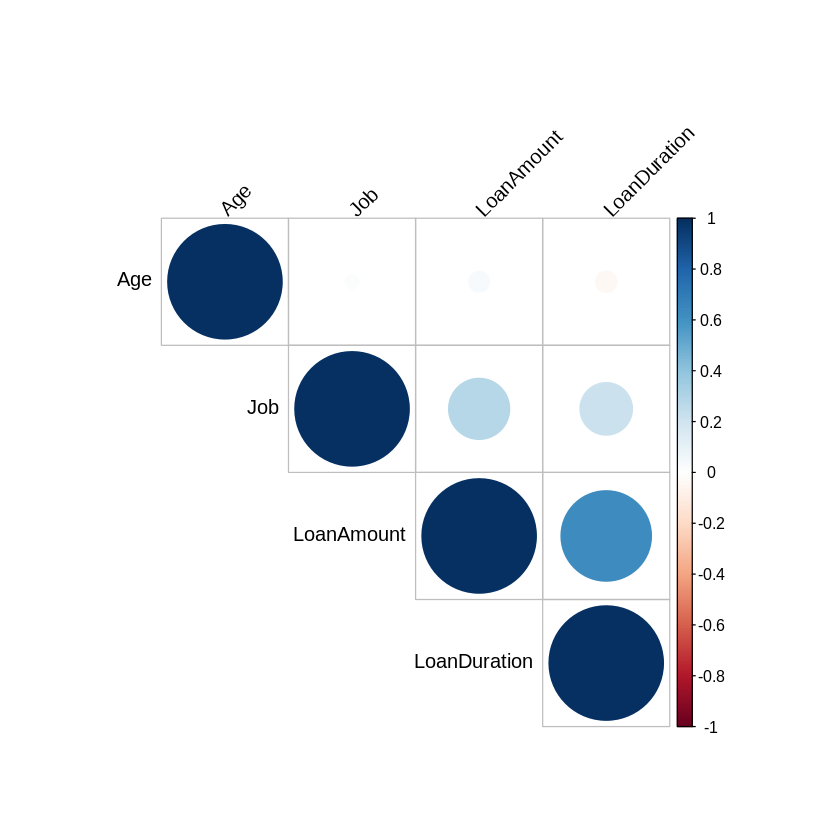

In [ ]:
# Select only numeric columns
numeric_cols <- select_if(german_credit_df, is.numeric)
corrplot(cor(numeric_cols, use = "pairwise.complete.obs"), method = "circle", type = "upper", tl.col = "black", tl.srt = 45)

In [ ]:
# Prepare data for t-test: Ensure IsDefault is a factor with exactly two levels and no NAs.
# `german_credit_df$IsDefault` should already be a factor (Good/Default) from Phase 2.2.
df_for_t_test <- german_credit_df %>%
  filter(!is.na(IsDefault)) %>% # Remove rows where IsDefault is NA (should be none if data is clean)
  droplevels() # Drop any unused levels, ensuring exactly two levels (Good, Default)

# IMPORTANT: Check if there are still exactly two levels after preprocessing.
# This diagnostic helps confirm the data's readiness for the t-test.
num_levels <- nlevels(df_for_t_test$IsDefault)
if (num_levels != 2) {
  print(paste("Warning: IsDefault factor has", num_levels, "levels after preprocessing. It must have exactly 2 levels for t-test."))
  print("Counts of each level:")
  print(table(df_for_t_test$IsDefault)) # This will show which levels are present and their counts.
} else {
  # Perform t-test only if there are exactly 2 levels.
  t_test_loan_amount <- t.test(LoanAmount ~ IsDefault, data = df_for_t_test)
  print(t_test_loan_amount)
  # Interpretation: Look at the p-value. If p < 0.05, the difference is statistically significant.
}


	Welch Two Sample t-test

data:  LoanAmount by IsDefault
t = -4.2642, df = 421.86, p-value = 2.478e-05
alternative hypothesis: true difference in means between group Good and group Default is not equal to 0
95 percent confidence interval:
 -1391.805  -513.534
sample estimates:
   mean in group Good mean in group Default 
             2985.457              3938.127 



In [ ]:
# Check the unique values and their counts in the IsDefault column
table(df_for_t_test$IsDefault)


   Good Default 
    700     300 

In [ ]:
chi_sq_checking_account <- chisq.test(table(german_credit_df$CheckingAccountStatus, german_credit_df$IsDefault))
print(chi_sq_checking_account)
# Interpretation: If p < 0.05, there's a statistically significant association.


	Pearson's Chi-squared test

data:  table(german_credit_df$CheckingAccountStatus, german_credit_df$IsDefault)
X-squared = 123.72, df = 3, p-value < 2.2e-16



In [ ]:
chi_sq_sex <- chisq.test(table(german_credit_df$Sex, german_credit_df$IsDefault))
print(chi_sq_sex)
# Interpretation: If p < 0.05, there's a statistically significant association.


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(german_credit_df$Sex, german_credit_df$IsDefault)
X-squared = 5.3485, df = 1, p-value = 0.02074



In [ ]:
# Example: Interaction between LoanDuration and LoanAmount
german_credit_df$LoanDuration_LoanAmount_Interaction <- german_credit_df$LoanDuration * german_credit_df$LoanAmount

In [ ]:
# Example: For a few categorical variables
# library(fastDummies)
# german_credit_df_dummies <- dummy_cols(german_credit_df,
#                                       select_columns = c("CheckingAccountStatus", "Purpose"),
#                                       remove_first_dummy = TRUE) # Remove one to avoid multicollinearity

In [ ]:
set.seed(123) # For reproducibility
index <- createDataPartition(german_credit_df$IsDefault, p = 0.8, list = FALSE)
train_df <- german_credit_df[index, ]
test_df <- german_credit_df[-index, ]

In [ ]:
# Formula for the model. Include all relevant features based on available columns.
train_df_model <- train_df %>%
  mutate_if(is.character, as.factor) %>%
  mutate(
    Sex = as.factor(Sex),
    Job = as.factor(Job), # Job is now integer, converting to factor
    Housing = as.factor(Housing),
    SavingAccountsStatus = as.factor(SavingAccountsStatus),
    CheckingAccountStatus = as.factor(CheckingAccountStatus), # Corrected column name
    Purpose = as.factor(Purpose),
    AgeGroup = as.factor(AgeGroup),
    LoanDurationCategory = as.factor(LoanDurationCategory)
  )

logistic_model <- glm(IsDefault ~
                         Age + Sex + Job + Housing + SavingAccountsStatus + CheckingAccountStatus +
                         LoanAmount + LoanDuration + Purpose,
                       data = train_df_model,
                       family = "binomial")

# Summarize the model results
summary(logistic_model)

# Interpret coefficients as Odds Ratios:
exp(coef(logistic_model))
exp(confint(logistic_model)) # Confidence intervals for odds ratios


Call:
glm(formula = IsDefault ~ Age + Sex + Job + Housing + SavingAccountsStatus + 
    CheckingAccountStatus + LoanAmount + LoanDuration + Purpose, 
    family = "binomial", data = train_df_model)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     4.689e-01  8.164e-01   0.574 0.565711    
Age                            -2.263e-02  8.900e-03  -2.543 0.011003 *  
Sexmale                        -3.764e-01  1.944e-01  -1.936 0.052905 .  
Job1                           -1.503e-02  5.730e-01  -0.026 0.979070    
Job2                           -7.639e-02  5.523e-01  -0.138 0.889988    
Job3                           -2.646e-01  5.946e-01  -0.445 0.656346    
Housingown                     -2.504e-01  3.044e-01  -0.823 0.410769    
Housingrent                     4.050e-02  3.578e-01   0.113 0.909865    
SavingAccountsStatusmoderate   -4.179e-01  3.024e-01  -1.382 0.166914    
SavingAccountsStatusNA         -9.488e-01  2.6

(Intercept)                            Age 
                     1.5982318                      0.9776250 
                       Sexmale                           Job1 
                     0.6863569                      0.9850802 
                          Job2                           Job3 
                     0.9264527                      0.7675394 
                    Housingown                    Housingrent 
                     0.7785028                      1.0413357 
  SavingAccountsStatusmoderate         SavingAccountsStatusNA 
                     0.6584008                      0.3871990 
SavingAccountsStatusquite rich       SavingAccountsStatusrich 
                     0.5602351                      0.4572729 
 CheckingAccountStatusmoderate        CheckingAccountStatusNA 
                     0.8015104                      0.1968969 
     CheckingAccountStatusrich                     LoanAmount 
                     0.4428156                      1.0000388 
                  LoanDuration                     Purposecar 
                     1.0372649                      1.0822257 
    Purposedomestic appliances               Purposeeducation 
                     1.6842929                      1.3011077 
    Purposefurniture/equipment                Purposeradio/TV 
                     0.8629467                      0.6626482 
                Purposerepairs         Purposevacation/others 
                     1.4242003                      0.6632209

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),0.3170406,7.8919145
Age,0.9604246,0.9945827
Sexmale,0.4688951,1.0057277
Job1,0.3230943,3.1329234
Job2,0.3167797,2.8395132
Job3,0.2415195,2.5438207
Housingown,0.4303298,1.4229150
Housingrent,0.5172102,2.1080227
SavingAccountsStatusmoderate,0.3584993,1.1773833
SavingAccountsStatusNA,0.2244202,0.6483529


In [ ]:
# --- DIAGNOSTIC STEP for train_df_model ---

# Check the structure of the prepared training data
print("Structure of train_df_model:")
str(train_df_model)

# Check unique values and levels for key categorical variables
print("\nUnique values and levels for categorical features in train_df_model:")

print("Sex:")
print(table(train_df_model$Sex, useNA = "always"))
print(paste("Number of levels for Sex:", nlevels(train_df_model$Sex)))

print("\nJob:")
print(table(train_df_model$Job, useNA = "always"))
print(paste("Number of levels for Job:", nlevels(train_df_model$Job)))

print("\nHousing:")
print(table(train_df_model$Housing, useNA = "always"))
print(paste("Number of levels for Housing:", nlevels(train_df_model$Housing)))

print("\nSavingAccountsStatus:")
print(table(train_df_model$SavingAccountsStatus, useNA = "always"))
print(paste("Number of levels for SavingAccountsStatus:", nlevels(train_df_model$SavingAccountsStatus)))

print("\nCheckingAccountStatus:")
print(table(train_df_model$CheckingAccountStatus, useNA = "always"))
print(paste("Number of levels for CheckingAccountStatus:", nlevels(train_df_model$CheckingAccountStatus)))

print("\nPurpose:")
print(table(train_df_model$Purpose, useNA = "always"))
print(paste("Number of levels for Purpose:", nlevels(train_df_model$Purpose)))

print("\nAgeGroup:")
print(table(train_df_model$AgeGroup, useNA = "always"))
print(paste("Number of levels for AgeGroup:", nlevels(train_df_model$AgeGroup)))

print("\nLoanDurationCategory:")
print(table(train_df_model$LoanDurationCategory, useNA = "always"))
print(paste("Number of levels for LoanDurationCategory:", nlevels(train_df_model$LoanDurationCategory)))

print("\nIsDefault (target variable):")
print(table(train_df_model$IsDefault, useNA = "always"))
print(paste("Number of levels for IsDefault:", nlevels(train_df_model$IsDefault)))

[1] "Structure of train_df_model:"
tibble [800 × 14] (S3: tbl_df/tbl/data.frame)
 $ Age                                : int [1:800] 20 20 20 20 20 20 20 20 20 20 ...
 $ Sex                                : Factor w/ 2 levels "female","male": 2 2 1 1 2 1 1 1 1 2 ...
 $ Job                                : Factor w/ 4 levels "0","1","2","3": 3 4 3 3 3 3 3 3 2 3 ...
 $ Housing                            : Factor w/ 3 levels "free","own","rent": 2 3 3 3 3 3 3 3 3 3 ...
 $ SavingAccountsStatus               : Factor w/ 5 levels "little","moderate",..: 1 1 3 1 1 4 5 1 1 3 ...
 $ CheckingAccountStatus              : Factor w/ 4 levels "little","moderate",..: 3 1 3 1 2 3 3 1 2 4 ...
 $ LoanAmount                         : int [1:800] 1313 1107 4675 1282 585 2221 3186 2039 2718 3617 ...
 $ LoanDuration                       : int [1:800] 9 12 12 12 12 15 15 18 24 24 ...
 $ Purpose                            : Factor w/ 8 levels "business","car",..: 5 6 2 5 6 5 2 5 2 5 ...
 $ RiskStatus        

Confusion Matrix and Statistics

          Reference
Prediction Good Default
   Good     123      37
   Default   17      23
                                          
               Accuracy : 0.73            
                 95% CI : (0.6628, 0.7902)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.198850        
                                          
                  Kappa : 0.2895          
                                          
 Mcnemar's Test P-Value : 0.009722        
                                          
            Sensitivity : 0.3833          
            Specificity : 0.8786          
         Pos Pred Value : 0.5750          
         Neg Pred Value : 0.7687          
             Prevalence : 0.3000          
         Detection Rate : 0.1150          
   Detection Prevalence : 0.2000          
      Balanced Accuracy : 0.6310          
                                          
       'Positive' Class : Default         
               

Setting levels: control = Good, case = Default

Setting direction: controls < cases



AUC: 0.7513095 


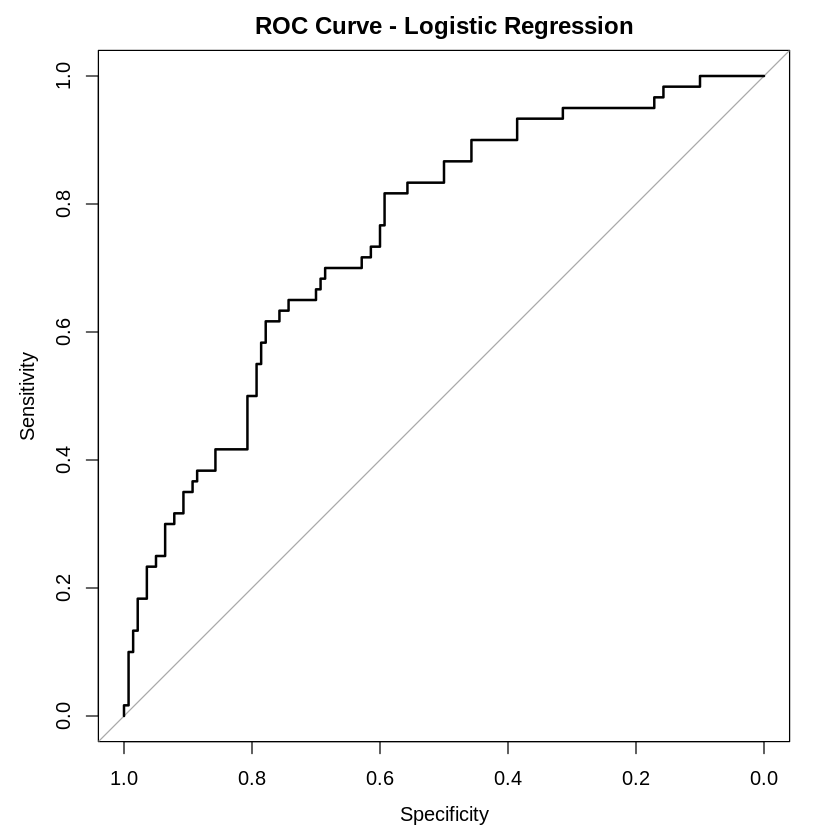

In [ ]:
# Prepare test_df for prediction to match the factor levels of train_df_model
test_df_model_eval <- test_df %>%
  mutate_if(is.character, as.factor) %>%
  mutate(
    Sex = as.factor(Sex),
    Job = as.factor(Job), # Ensure Job is a factor here too
    Housing = as.factor(Housing),
    SavingAccountsStatus = as.factor(SavingAccountsStatus),
    CheckingAccountStatus = as.factor(CheckingAccountStatus),
    Purpose = as.factor(Purpose),
    AgeGroup = as.factor(AgeGroup),
    LoanDurationCategory = as.factor(LoanDurationCategory)
  )

# Ensure the target variable `IsDefault` in test_df_model_eval is a factor with exactly two levels: 'Good', 'Default'
test_df_model_eval$IsDefault <- factor(test_df_model_eval$IsDefault, levels = c("Good", "Default"))

# Make predictions on the test set using the prepared test_df_model_eval
predictions_prob <- predict(logistic_model, newdata = test_df_model_eval, type = "response")
predictions_class <- factor(ifelse(predictions_prob > 0.5, "Default", "Good"), levels = c("Good", "Default"))

# Create confusion matrix
confusion_matrix <- confusionMatrix(predictions_class, test_df_model_eval$IsDefault, positive = "Default")
print(confusion_matrix)

# Extract metrics
accuracy <- confusion_matrix$overall['Accuracy']
precision <- confusion_matrix$byClass['Pos Pred Value']
recall <- confusion_matrix$byClass['Sensitivity']
f1_score <- confusion_matrix$byClass['F1']

cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall (Sensitivity):", recall, "\n")
cat("F1-Score:", f1_score, "\n")

# ROC Curve and AUC
roc_obj <- roc(response = test_df_model_eval$IsDefault, predictor = predictions_prob)
plot(roc_obj, main = "ROC Curve - Logistic Regression")
auc_value <- auc(roc_obj)
cat("AUC:", auc_value, "\n")

In [ ]:
# Predict probabilities for the entire dataset (or just test_df if preferred)
# Ensure german_credit_df is prepared similarly before prediction
german_credit_df_prepared_for_predict <- german_credit_df %>%
  mutate_if(is.character, as.factor) %>%
  mutate(
    Sex = as.factor(Sex),
    Job = as.factor(Job),
    Housing = as.factor(Housing),
    SavingAccountsStatus = as.factor(SavingAccountsStatus),
    CheckingAccountStatus = as.factor(CheckingAccountStatus),
    Purpose = as.factor(Purpose),
    AgeGroup = as.factor(AgeGroup),
    LoanDurationCategory = as.factor(LoanDurationCategory)
  )
# Ensure IsDefault in german_credit_df_prepared_for_predict is a factor
german_credit_df_prepared_for_predict$IsDefault <- factor(german_credit_df_prepared_for_predict$IsDefault, levels = c("Good", "Default"))


german_credit_df_final <- german_credit_df # Start with original for adding new columns
german_credit_df_final$PredictedProb <- predict(logistic_model, newdata = german_credit_df_prepared_for_predict, type = "response")

# Assign Risk Tier based on probabilities
german_credit_df_final$Risk_Tier <- cut(german_credit_df_final$PredictedProb,
                                 breaks = c(-Inf, 0.2, 0.5, Inf),
                                 labels = c("Low Risk", "Medium Risk", "High Risk"),
                                 right = TRUE, include.lowest = TRUE)

# You might also want to add key statistical test results as new columns
# (e.g., p-value for LoanAmount T-test, Chi-squared p-value for CheckingAccountStatus, Sex)
# This makes it easier to display in Looker Studio.
# IMPORTANT: Ensure t_test_loan_amount and chi_sq_checking_account, chi_sq_sex are defined
# before running these lines. If the t-test couldn't run, these will be undefined.
# You might need to set them to NA or a placeholder if the test itself fails.
german_credit_df_final$LoanAmount_Ttest_Pvalue <- if(exists("t_test_loan_amount")) t_test_loan_amount$p.value else NA
german_credit_df_final$CheckingAccountStatus_Chisq_Pvalue <- if(exists("chi_sq_checking_account")) chi_sq_checking_account$p.value else NA
german_credit_df_final$Sex_Chisq_Pvalue <- if(exists("chi_sq_sex")) chi_sq_sex$p.value else NA


# To write back to BigQuery:
# First, ensure you are re-authenticated and have write access.
# Convert factors back to character or numeric if bigrquery has issues with factors directly.
german_credit_df_to_bq <- german_credit_df_final %>% # Use german_credit_df_final here
  mutate_if(is.factor, as.character) %>%
  mutate(IsDefault = ifelse(IsDefault == "Default", 1, 0)) # Convert back to 0/1 for BQ

dbWriteTable(con,
             name = "german_credit_r_analyzed", # New table name
             value = german_credit_df_to_bq,
             overwrite = TRUE) # BE CAREFUL with overwrite, make sure you're writing to a NEW table

In [ ]:
install.packages("ROSE") # If not already installed
library(ROSE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loaded ROSE 0.0-4




In [ ]:
# Set up training control for cross-validation
control <- trainControl(method = "cv", # Cross-validation
                        number = 10,  # 10 folds
                        classProbs = TRUE, # Important for ROC and probabilities
                        summaryFunction = twoClassSummary) # For binary classification metrics like AUC

In [ ]:
# Make sure all columns used are appropriate for Random Forest (numeric or factor)
# Convert all character columns to factors if not already done for both train_df and test_df
train_df_model_rf <- train_df %>%
    mutate_if(is.character, as.factor) %>%
    mutate(
        Sex = as.factor(Sex),
        Job = as.factor(Job),
        Housing = as.factor(Housing),
        SavingAccountsStatus = as.factor(SavingAccountsStatus),
        CheckingAccountStatus = as.factor(CheckingAccountStatus), # Corrected column name
        Purpose = as.factor(Purpose),
        AgeGroup = as.factor(AgeGroup),
        LoanDurationCategory = as.factor(LoanDurationCategory)
    )

# Ensure the target variable `IsDefault` is a factor with exactly two levels: 'Good', 'Default'
train_df_model_rf$IsDefault <- factor(train_df_model_rf$IsDefault, levels = c("Good", "Default"))


set.seed(123)
rf_model <- train(IsDefault ~
                       Age + Sex + Job + Housing + SavingAccountsStatus + CheckingAccountStatus +
                       LoanAmount + LoanDuration + Purpose,
                 data = train_df_model_rf,
                 method = "rf", # Random Forest
                 metric = "ROC", # Optimize for ROC/AUC
                 trControl = control,
                 importance = TRUE) # To get feature importance

print(rf_model)
plot(rf_model) # Plot tuning results

# Get and plot feature importance using caret's varImp and ggplot2
importance_rf_plot <- varImp(rf_model, scale = FALSE)
plot(importance_rf_plot, main = "Random Forest Feature Importance") # This uses caret's default plot for varImp

ERROR: Error: Required packages are missing: randomForest


In [ ]:
install.packages(c("DBI", "bigrquery", "dplyr", "ggplot2", "caret", "e1071", "pROC", "stats", "corrplot", "ROSE", "randomForest", "gbm"))
set.seed(123)
gbm_model <- train(IsDefault ~
                       Age + Sex + Job + Housing + SavingAccountsStatus + CheckingAccountStatus +
                       LoanAmount + LoanDuration + Purpose,
                      data = train_df_model_rf, # Use the same processed training data
                      method = "gbm",
                      metric = "ROC",
                      trControl = control,
                      verbose = FALSE) # Suppress verbose output during training

print(gbm_model)
plot(gbm_model)
summary(gbm_model$finalModel) # Feature importance for GBM

In [ ]:
# Ensure test_df has the same factor levels for IsDefault
test_df_model_eval <- test_df %>%
    mutate_if(is.character, as.factor) %>%
    mutate(
        Sex = as.factor(Sex),
        Job = as.factor(Job),
        Housing = as.factor(Housing),
        SavingAccountsStatus = as.factor(SavingAccountsStatus),
        CheckingAccountStatus = as.factor(CheckingAccountStatus), # Corrected column name
        Purpose = as.factor(Purpose),
        AgeGroup = as.factor(AgeGroup),
        LoanDurationCategory = as.factor(LoanDurationCategory)
    )

test_df_model_eval$IsDefault <- factor(test_df_model_eval$IsDefault, levels = c("Good", "Default"))


# Logistic Regression (from Stage 2)
predictions_lr_prob <- predict(logistic_model, newdata = test_df_model_eval, type = "response")
predictions_lr_class <- factor(ifelse(predictions_lr_prob > 0.5, "Default", "Good"), levels = c("Good", "Default"))

# Random Forest
predictions_rf_prob <- predict(rf_model, newdata = test_df_model_eval, type = "prob")[,"Default"]
predictions_rf_class <- predict(rf_model, newdata = test_df_model_eval)

# GBM
predictions_gbm_prob <- predict(gbm_model, newdata = test_df_model_eval, type = "prob")[,"Default"]
predictions_gbm_class <- predict(gbm_model, newdata = test_df_model_eval)


In [ ]:
# Function to get metrics
get_metrics <- function(actual, predicted_class, predicted_prob, model_name) {
  cm <- confusionMatrix(predicted_class, actual, positive = "Default")
  roc_obj <- roc(response = actual, predictor = predicted_prob)

  data.frame(
    Model = model_name,
    Accuracy = cm$overall['Accuracy'],
    Precision = cm$byClass['Pos Pred Value'],
    Recall = cm$byClass['Sensitivity'],
    F1_Score = cm$byClass['F1'],
    AUC = auc(roc_obj)
  )
}

metrics_lr <- get_metrics(test_df_model_eval$IsDefault, predictions_lr_class, predictions_lr_prob, "Logistic Regression")
metrics_rf <- get_metrics(test_df_model_eval$IsDefault, predictions_rf_class, predictions_rf_prob, "Random Forest")
metrics_gbm <- get_metrics(test_df_model_eval$IsDefault, predictions_gbm_class, predictions_gbm_prob, "GBM")

all_model_metrics <- rbind(metrics_lr, metrics_rf, metrics_gbm)
print(all_model_metrics)

In [ ]:
# Plotting multiple ROC curves on one plot
roc_lr <- roc(response = test_df_model_eval$IsDefault, predictor = predictions_lr_prob)
roc_rf <- roc(response = test_df_model_eval$IsDefault, predictor = predictions_rf_prob)
roc_gbm <- roc(response = test_df_model_eval$IsDefault, predictor = predictions_gbm_prob)

plot(roc_lr, col = "red", main = "ROC Curves for Credit Default Models")
lines(roc_rf, col = "blue")
lines(roc_gbm, col = "green")
legend("bottomright",
       legend = c(paste0("Logistic Regression (AUC = ", round(auc(roc_lr), 3), ")"),
                  paste0("Random Forest (AUC = ", round(auc(roc_rf), 3), ")"),
                  paste0("GBM (AUC = ", round(auc(roc_gbm), 3), ")")),
       col = c("red", "blue", "green"),
       lty = 1,
       lwd = 2)

In [ ]:
# Prepare the full german_credit_df to match the factor levels used during model training
german_credit_df_prepared_for_predict <- german_credit_df %>%
  mutate_if(is.character, as.factor) %>%
  mutate(
    Sex = as.factor(Sex),
    Job = as.factor(Job),
    Housing = as.factor(Housing),
    SavingAccountsStatus = as.factor(SavingAccountsStatus),
    CheckingAccountStatus = as.factor(CheckingAccountStatus), # Corrected column name
    Purpose = as.factor(Purpose),
    AgeGroup = as.factor(AgeGroup),
    LoanDurationCategory = as.factor(LoanDurationCategory)
  )

# Ensure IsDefault in german_credit_df_prepared_for_predict is a factor
german_credit_df_prepared_for_predict$IsDefault <- factor(german_credit_df_prepared_for_predict$IsDefault, levels = c("Good", "Default"))


german_credit_df_final <- german_credit_df # Start with original for adding new columns
german_credit_df_final$PredictedDefaultProb <- predict(rf_model, newdata = german_credit_df_prepared_for_predict, type = "prob")[,"Default"]

In [ ]:
# Define thresholds for risk tiers. These are business decisions!
# Example thresholds:
# < 0.20 probability = Low Risk
# 0.20 to < 0.40 probability = Medium Risk
# >= 0.40 probability = High Risk
german_credit_df_final$Risk_Tier <- cut(german_credit_df_final$PredictedDefaultProb,
                                        breaks = c(-Inf, 0.20, 0.40, Inf),
                                        labels = c("Low Risk", "Medium Risk", "High Risk"),
                                        right = TRUE, include.lowest = TRUE)

# Check distribution of risk tiers
table(german_credit_df_final$Risk_Tier)

In [ ]:
# For Random Forest:
importance_rf <- varImp(rf_model, scale = FALSE) # scale=FALSE gives raw importance
print(importance_rf)
# You might want to convert this to a data frame and sort.
# For GBM: summary(gbm_model$finalModel)

# Convert to data frame for BigQuery push
feature_importance_df <- as.data.frame(importance_rf$importance)
feature_importance_df$Feature <- rownames(feature_importance_df)
colnames(feature_importance_df)[1] <- "Importance" # Rename first column
feature_importance_df <- feature_importance_df %>%
  arrange(desc(Importance)) %>%
  select(Feature, Importance) # Reorder columns

In [ ]:
# Make sure to handle factors/characters for BigQuery compatibility
german_credit_df_to_bq <- german_credit_df_final %>% # Use german_credit_df_final here
  mutate_if(is.factor, as.character) %>%
  mutate(IsDefault = ifelse(IsDefault == "Default", 1, 0)) # Convert back to 0/1 for BQ

# Writing to a NEW BigQuery table to avoid schema conflicts from previous stages
dbWriteTable(con,
             name = "german_credit_r_analyzed_final", # Changed table name to avoid conflict
             value = german_credit_df_to_bq,
             overwrite = TRUE) # BE CAREFUL with overwrite, make sure you're writing to a NEW table

# Write the model metrics table (for all models)
dbWriteTable(con,
             name = "all_model_metrics_summary", # Table for all model metrics (LR, RF, GBM)
             value = all_model_metrics,
             overwrite = TRUE)

# Write the feature importance table (using the best model's importance)
dbWriteTable(con,
             name = "best_model_feature_importance", # Table for feature importance
             value = feature_importance_df,
             overwrite = TRUE)


In [ ]:
install.packages("PRROC")
library(PRROC)

# Ensure 'test_df_model_eval' and 'predictions_rf_prob' are available in your R environment.
# These variables should have been created in the earlier phases of your analysis (Phase 3.2).

# Calculate Precision-Recall points for plotting
if (exists("test_df_model_eval") && exists("predictions_rf_prob")) {
  pr_curve <- pr.curve(scores.class0 = predictions_rf_prob[test_df_model_eval$IsDefault == "Default"],
                       scores.class1 = predictions_rf_prob[test_df_model_eval$IsDefault == "Good"],
                       curve = TRUE)

  # Extract precision and recall points
  pr_data <- as.data.frame(pr_curve$curve)
  colnames(pr_data) <- c("Recall", "Precision", "Threshold")

  # Print the first few rows of the precision-recall data
  print(head(pr_data))

  # Note: To push this 'pr_data' to BigQuery, you would need to ensure your
  # BigQuery connection 'con' is active and then use dbWriteTable.
  # Example (assuming 'con' is established):
  # dbWriteTable(con,
  #              name = "precision_recall_tradeoff",
  #              value = pr_data,
  #              overwrite = TRUE)

} else {
  print("Cannot generate Precision-Recall curve data: test_df_model_eval or predictions_rf_prob not found. Please ensure previous steps in Phase 3.2 have been run.")
}

In [ ]:
# Ensure test_df_model_eval is prepared and predictions are available from Phase 3.2

# Combine predicted probabilities for all models
prob_distribution_data <- data.frame(
  PredictedProb = c(predictions_lr_prob, predictions_rf_prob, predictions_gbm_prob),
  ActualStatus = rep(test_df_model_eval$IsDefault, 3), # Repeat actual status for each model
  Model = c(rep("Logistic Regression", length(predictions_lr_prob)),
            rep("Random Forest", length(predictions_rf_prob)),
            rep("GBM", length(predictions_gbm_prob)))
)

# Convert ActualStatus back to 0/1 for BigQuery compatibility if needed
prob_distribution_data$ActualStatus <- ifelse(prob_distribution_data$ActualStatus == "Default", 1, 0)

# Push to BigQuery
# Ensure 'con' (BigQuery connection) is active
dbWriteTable(con,
             name = "predicted_prob_distributions",
             value = prob_distribution_data,
             overwrite = TRUE)

print("Predicted probability distribution data pushed to BigQuery as 'predicted_prob_distributions'.")

In [ ]:
# Ensure test_df_model_eval and predictions (prob & class) for all models are available from Phase 3.2

calculate_f1_curve <- function(actual, predicted_prob, model_name) {
  thresholds <- seq(0.05, 0.95, by = 0.01) # Define a range of thresholds
  f1_scores <- numeric(length(thresholds))
  precision_scores <- numeric(length(thresholds))
  recall_scores <- numeric(length(thresholds))

  for (i in seq_along(thresholds)) {
    threshold <- thresholds[i]
    predicted_class_at_threshold <- factor(ifelse(predicted_prob > threshold, "Default", "Good"), levels = c("Good", "Default"))
    cm <- confusionMatrix(predicted_class_at_threshold, actual, positive = "Default")

    # Handle cases where a metric might be NaN (e.g., no positive predictions)
    precision_val <- ifelse(is.na(cm$byClass['Pos Pred Value']), 0, cm$byClass['Pos Pred Value'])
    recall_val <- ifelse(is.na(cm$byClass['Sensitivity']), 0, cm$byClass['Sensitivity'])

    # Calculate F1-score, handle division by zero
    f1_scores[i] <- ifelse((precision_val + recall_val) == 0, 0, 2 * (precision_val * recall_val) / (precision_val + recall_val))
    precision_scores[i] <- precision_val
    recall_scores[i] <- recall_val
  }

  data.frame(
    Model = model_name,
    Threshold = thresholds,
    F1_Score = f1_scores,
    Precision = precision_scores,
    Recall = recall_scores # Include for potential future use or tooltip
  )
}

f1_lr_data <- calculate_f1_curve(test_df_model_eval$IsDefault, predictions_lr_prob, "Logistic Regression")
f1_rf_data <- calculate_f1_curve(test_df_model_eval$IsDefault, predictions_rf_prob, "Random Forest")
f1_gbm_data <- calculate_f1_curve(test_df_model_eval$IsDefault, predictions_gbm_prob, "GBM")

all_f1_data <- rbind(f1_lr_data, f1_rf_data, f1_gbm_data)

# Push to BigQuery
# Ensure 'con' (BigQuery connection) is active
dbWriteTable(con,
             name = "f1_score_by_threshold",
             value = all_f1_data,
             overwrite = TRUE)

print("F1-score by threshold data pushed to BigQuery as 'f1_score_by_threshold'.")

In [ ]:
# Ensure test_df_model_eval and predictions (prob) for all models are available from Phase 3.2

calculate_gains_curve <- function(actual, predicted_prob, model_name) {
  df <- data.frame(actual = actual, predicted_prob = predicted_prob)
  df <- df[order(-df$predicted_prob), ] # Sort by predicted probability descendingj=

  n_total <- nrow(df)
  n_defaults_total <- sum(df$actual == "Default")

  cumulative_gains <- data.frame()

  for (i in 1:100) { # Calculate for every 1% of the population
    percent_population <- i / 100
    num_records_to_consider <- floor(n_total * percent_population)
    if (num_records_to_consider == 0) next # Skip if no records for this percentage

    subset_df <- head(df, num_records_to_consider)
    cumulative_defaults_captured <- sum(subset_df$actual == "Default")

    # Percentage of total defaults captured
    percent_defaults_captured <- (cumulative_defaults_captured / n_defaults_total) * 100

    cumulative_gains <- rbind(cumulative_gains, data.frame(
      Model = model_name,
      PercentPopulation = percent_population * 100,
      PercentDefaultsCaptured = percent_defaults_captured
    ))
  }
  return(cumulative_gains)
}

gains_lr_data <- calculate_gains_curve(test_df_model_eval$IsDefault, predictions_lr_prob, "Logistic Regression")
gains_rf_data <- calculate_gains_curve(test_df_model_eval$IsDefault, predictions_rf_prob, "Random Forest")
gains_gbm_data <- calculate_gains_curve(test_df_model_eval$IsDefault, predictions_gbm_prob, "GBM")

all_gains_data <- rbind(gains_lr_data, gains_rf_data, gains_gbm_data)

# Add a random baseline
random_baseline <- data.frame(
  Model = "Random Baseline",
  PercentPopulation = seq(1, 100, by = 1),
  PercentDefaultsCaptured = seq(1, 100, by = 1)
)
all_gains_data <- rbind(all_gains_data, random_baseline)


# Push to BigQuery
# Ensure 'con' (BigQuery connection) is active
dbWriteTable(con,
             name = "cumulative_gains_data",
             value = all_gains_data,
             overwrite = TRUE)

print("Cumulative gains data pushed to BigQuery as 'cumulative_gains_data'.")

In [ ]:
# R Code for preparing data for "Cumulative Lift by Model" chart

# This code snippet assumes that 'test_df_model_eval' and
# predicted probabilities (predictions_lr_prob, predictions_rf_prob, predictions_gbm_prob)
# are already available in your R environment from Phase 3.2.
# It also assumes 'con' (BigQuery connection) is active.

# Function to calculate data points for a Lift Curve
calculate_lift_curve <- function(actual, predicted_prob, model_name) {
  df <- data.frame(actual = actual, predicted_prob = predicted_prob)
  df <- df[order(-df$predicted_prob), ] # Sort by predicted probability descending

  n_total <- nrow(df)
  n_defaults_total <- sum(df$actual == "Default")

  lift_data <- data.frame()

  # Calculate for every 1% of the population
  for (i in 1:100) {
    percent_population_val <- i / 100
    num_records_to_consider <- floor(n_total * percent_population_val)

    if (num_records_to_consider == 0) {
      # Handle cases where percentage is too small for any records
      cumulative_defaults_captured <- 0
    } else {
      subset_df <- head(df, num_records_to_consider)
      cumulative_defaults_captured <- sum(subset_df$actual == "Default")
    }

    # Percentage of total defaults captured
    percent_defaults_captured_val <- ifelse(n_defaults_total == 0, 0, (cumulative_defaults_captured / n_defaults_total) * 100)

    # Calculate Lift
    # Avoid division by zero if PercentPopulation is 0 (first point)
    lift_val <- ifelse(percent_population_val == 0, 0, percent_defaults_captured_val / (percent_population_val * 100))

    lift_data <- rbind(lift_data, data.frame(
      Model = model_name,
      PercentPopulation = percent_population_val * 100, # Convert to 0-100 scale for plotting
      PercentDefaultsCaptured = percent_defaults_captured_val,
      Lift = lift_val
    ))
  }
  return(lift_data)
}

# Calculate Lift data for each model
lift_lr_data <- calculate_lift_curve(test_df_model_eval$IsDefault, predictions_lr_prob, "Logistic Regression")
lift_rf_data <- calculate_lift_curve(test_df_model_eval$IsDefault, predictions_rf_prob, "Random Forest")
lift_gbm_data <- calculate_lift_curve(test_df_model_eval$IsDefault, predictions_gbm_prob, "GBM")

# Combine all model lift data
all_lift_data <- rbind(lift_lr_data, lift_rf_data, lift_gbm_data)

# Add a random baseline (Lift = 1 for all population percentages)
random_baseline_lift <- data.frame(
  Model = "Random Baseline",
  PercentPopulation = seq(1, 100, by = 1),
  PercentDefaultsCaptured = seq(1, 100, by = 1), # For consistency, though not strictly needed for Lift calc
  Lift = 1 # Random baseline has a lift of 1
)
all_lift_data <- rbind(all_lift_data, random_baseline_lift)

# Push the combined Lift data to BigQuery
# Ensure 'con' is the active BigQuery connection
dbWriteTable(con,
             name = "cumulative_lift_data", # New table name for lift data
             value = all_lift_data,
             overwrite = TRUE)

print("Cumulative Lift data pushed to BigQuery as 'cumulative_lift_data'.")